## 使用GAN进行图片样本生成

In [3]:
# 包
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image

### 工具函数声明

In [56]:
# 定义两个函数

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

# 重置梯度
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [50]:
# 超参数设置
# Hyper-parameters
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 200
batch_size = 100
sample_dir = 'samples'

In [51]:
# 如果没有文件夹就创建一个文件夹
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

### 图像预处理转化器声明

In [52]:
# 图像处理模块：transform设置
# Image processing：归一化（将数据规整到[-1,1],计算公式：channel=（channel-mean）/std）
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5],
                                     std=[0.5]
                )]
)

### 数据加载和预处理

In [53]:
# 加载同时做transform预处理
mnist = torchvision.datasets.MNIST(root='../../../data/minist',
                                   train=True,
                                   transform=transform,
                                   download=True)
# 数据加载器：GAN中只考虑判别模型和生成模型的对抗提高，无需设置训练集和测试集
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size, 
                                          shuffle=True)



### 模型结构搭建

In [54]:
# 创建判别模型
# Discriminator
D = nn.Sequential(
        nn.Linear(image_size, hidden_size), # 判别的输入时图像数据
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, 1),
        nn.Sigmoid())

# 创建生成模型
# Generator 
G = nn.Sequential(
        nn.Linear(latent_size, hidden_size), # 生成的输入是随机数，可以自己定义
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, image_size),
        nn.Tanh())

### 损失函数、优化器设置

In [55]:
# 设置损失函数和优化器
criterion = nn.BCELoss() # 二值交叉熵 Binary cross entropy loss
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

### 模型训练

In [ ]:
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        
        images = images.reshape(batch_size, -1)
            
        # 创建标签，随后会用于损失函数BCE loss的计算
        real_labels = torch.ones(batch_size, 1)  # true_label设为1，表示True
        fake_labels = torch.zeros(batch_size, 1) # fake_label设为0，表示False

        # ================================================================== #
        #                      训练判别模型                      #
        # ================================================================== #

        # 计算real_损失
        # 使用公式 BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))，来计算realimage的判别损失
        # 其中第二项永远为零，因为real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        
        # 计算fake损失
        # 生成模型根据随机输入生成fake_images
        z = torch.randn(batch_size, latent_size)
        fake_images = G(z) 
        # 使用公式 BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))，来计算fakeImage的判别损失
        # 其中第一项永远为零，因为fake_labels == 0
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 反向传播和优化
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # ================================================================== #
        #                       训练生成模型                       #
        # ================================================================== #

        # 生成模型根据随机输入生成fake_images,然后判别模型进行判别
        z = torch.randn(batch_size, latent_size)
        fake_images = G(z)
        outputs = D(fake_images)
        
        # 使用反标签的二进制交叉熵损失函数进行生成器损失函数计算
        g_loss = criterion(outputs, real_labels)
        
        # 反向传播和优化
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    
    # 在第一轮保存训练数据图像
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
    # 每一轮保存 生成的样本（即fake_images）
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

### 对抗样本生成效果展示

In [61]:
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np

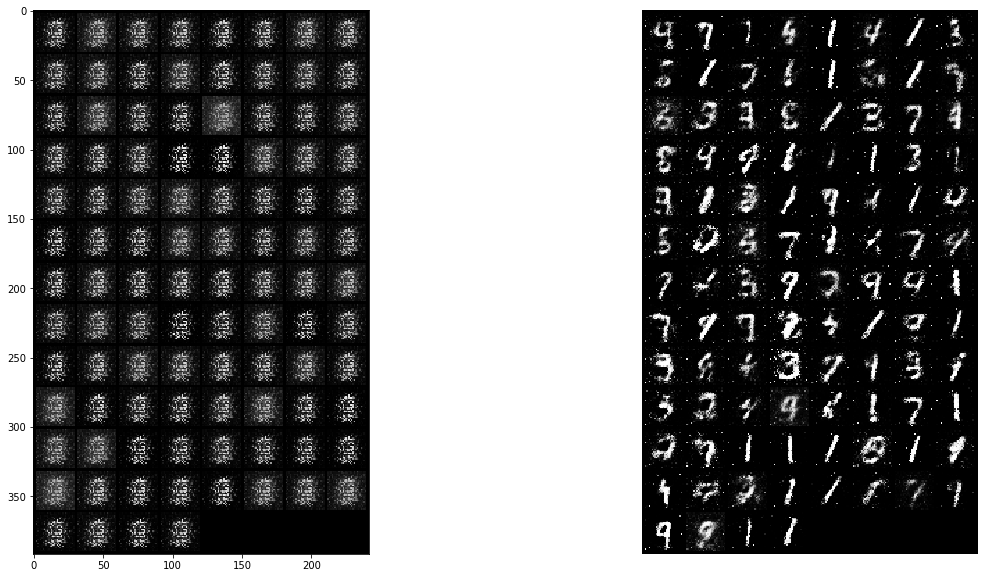

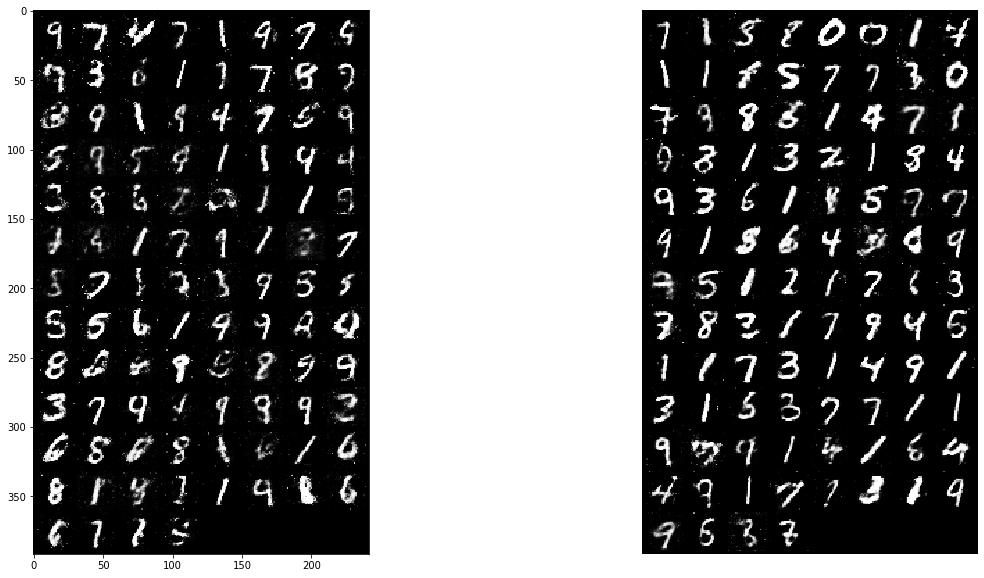

In [62]:
# 起始阶段
fakePath1 = './samples/fake_images-1.png'
fakeImg1 = mpimg.imread(fakePath1)

fakePath5 = './samples/fake_images-50.png'
fakeImg5 = mpimg.imread(fakePath5)



plt.figure(figsize=(20,10))
plt.subplot(1,2,1 ) # 显示图片
plt.imshow(fakeImg1) # 显示图片
plt.subplot(1,2,2 ) # 显示图片
plt.imshow(fakeImg5) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

fakePath195 = './samples/fake_images-100.png'
fakeImg195 = mpimg.imread(fakePath195)

fakePath200 = './samples/fake_images-200.png'
fakeImg200 = mpimg.imread(fakePath200)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1 ) # 显示图片
plt.imshow(fakeImg195) # 显示图片
plt.subplot(1,2,2 ) # 显示图片
plt.imshow(fakeImg200) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()